In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BDay
from tqdm import tqdm

pd.set_option("display.max_columns", None)

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

In [2]:
def get_plot_data(bottom_quintile_end, mean=True):
    if mean:
        return pd.concat([pd.DataFrame({'event_day': [-23], 'abret_cum': [1]}), bottom_quintile_end.groupby('event_day').mean()['abret_cum'].reset_index()]).set_index('event_day')
    else:
        return pd.concat([pd.DataFrame({'event_day': [-23], 'abret_cum': [1]}), bottom_quintile_end.groupby('event_day').median()['abret_cum'].reset_index()]).set_index('event_day')
    
def get_plot_data_turnover(bottom_quintile_end, mean=True):
    if mean:
        return bottom_quintile_end.groupby('event_day').mean()['ab_turnover'].reset_index().set_index('event_day')
    else:
        return bottom_quintile_end.groupby('event_day').mean()['ab_turnover'].reset_index().set_index('event_day')
    
def get_boj_quintiles_conditional(sue_df_boj_merged, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['SEDOL', 'qtr_yr_index', 'boj_share_shares']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby('qtr_yr_index')): 
        try:
            df['boj_share_shares_quantiles_'+suffix] = pd.qcut(df['boj_share_shares'], quantiles, labels=False)
        except: 
            df['boj_share_shares_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['SEDOL', 'qtr_yr_index', 'boj_share_shares'])
    return sue_df_boj_merged

def get_sue_quintiles_conditional(sue_df_boj_merged, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['SEDOL', 'qtr_yr_index', 'sue_nm']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby('qtr_yr_index')): 
        try:
            df['sue_nm_quantiles_'+suffix] = pd.qcut(df['sue_nm'], quantiles, labels=False)
        except: 
            df['sue_nm_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['SEDOL', 'qtr_yr_index', 'sue_nm'])
    return sue_df_boj_merged

def get_firm_quarter_count(df):
    return df.drop_duplicates(['SEDOL', 'eff_anndats'])

def get_num_fm_qtrs(df): 
    return len(df.drop_duplicates(['SEDOL', 'eff_anndats']))

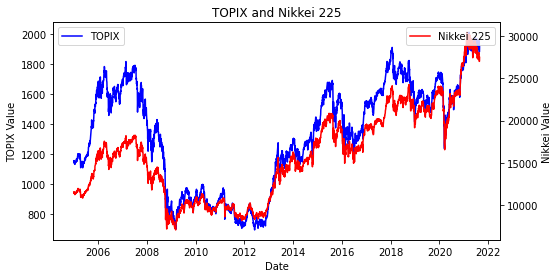

In [3]:
topix_df = pd.read_csv(PATH+'raw_data/datastream/topix_daily_returns.csv', parse_dates=['valuedate'])
nikkei_df = pd.read_csv(PATH+'raw_data/datastream/nikkei_daily_returns.csv', parse_dates=['valuedate'])

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(topix_df[['valuedate', 'pi_']].set_index('valuedate'), color='b', label='TOPIX')

ax2 = ax.twinx()
ax2.plot(nikkei_df[['valuedate', 'pi_']].set_index('valuedate'), color='r', label='Nikkei 225')

ax.set_title('TOPIX and Nikkei 225')
ax.set_xlabel('Date')
ax.set_ylabel('TOPIX Value')
ax2.set_ylabel('Nikkei Value')

ax.legend(loc=0)
ax2.legend(loc=1)

plt.show()

del topix_df 
del nikkei_df

In [4]:
sue_df_final = pd.read_pickle(PATH+'checkpoint_data/sue_df_final.pkl')

## Top Quintile SUEs, Unconditional

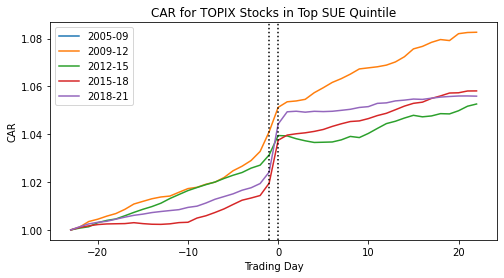

In [5]:
date0, date1 = pd.to_datetime('2005-01-01'), pd.to_datetime('2009-01-01')
date2, date3 = pd.to_datetime('2012-01-01'), pd.to_datetime('2015-01-01')
date4, date5 = pd.to_datetime('2018-01-01'), pd.to_datetime('2021-01-01')

top_quintile = sue_df_final[sue_df_final['sue_nm_quintiles']==4]

top_quintile_period_0 = top_quintile[(top_quintile['eff_anndats'] >= date0) & (top_quintile['eff_anndats'] <= date1)]
top_quintile_period_1 = top_quintile[(top_quintile['eff_anndats'] >= date1) & (top_quintile['eff_anndats'] <= date2)]
top_quintile_period_2 = top_quintile[(top_quintile['eff_anndats'] >= date2) & (top_quintile['eff_anndats'] <= date3)]
top_quintile_period_3 = top_quintile[(top_quintile['eff_anndats'] >= date3) & (top_quintile['eff_anndats'] <= date4)]
top_quintile_period_4 = top_quintile[(top_quintile['eff_anndats'] >= date4) & (top_quintile['eff_anndats'] <= date5)]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(top_quintile_period_0), label='2005-09')
plt.plot(get_plot_data(top_quintile_period_1), label='2009-12')
plt.plot(get_plot_data(top_quintile_period_2), label='2012-15')
plt.plot(get_plot_data(top_quintile_period_3), label='2015-18')
plt.plot(get_plot_data(top_quintile_period_4), label='2018-21')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for TOPIX Stocks in Top SUE Quintile')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

# plt.savefig('images/top_sue_decile_car')
plt.show()

## Top Quintile SUEs, Within Nikkei, BOJ Share Conditional

In [6]:
nk_sue_df = sue_df_final[sue_df_final['nk_flag']==1]
nk_sue_df = get_sue_quintiles_conditional(nk_sue_df, suffix='nk', quantiles=10)
nk_sue_df = get_boj_quintiles_conditional(nk_sue_df, suffix='nk', quantiles=10)

100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 235.75it/s]


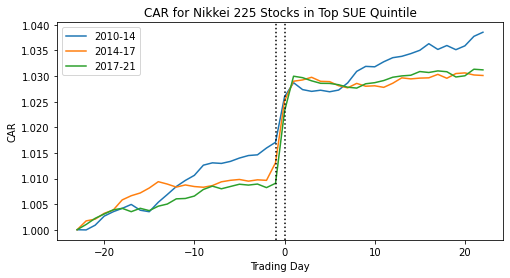

In [7]:
date0, date1 = pd.to_datetime('2005-01-01'), pd.to_datetime('2008-01-01')
date2, date3 = pd.to_datetime('2010-01-01'), pd.to_datetime('2014-01-01')
date4, date5 = pd.to_datetime('2017-01-01'), pd.to_datetime('2021-01-01')

top_quintile = nk_sue_df[nk_sue_df['sue_nm_quantiles_nk'].isin([9, 8])]

# top_quintile_period_0 = top_quintile[(top_quintile['eff_anndats'] >= date0) & (top_quintile['eff_anndats'] <= date1)]
# top_quintile_period_1 = top_quintile[(top_quintile['eff_anndats'] >= date1) & (top_quintile['eff_anndats'] <= date2)]
top_quintile_period_2 = top_quintile[(top_quintile['eff_anndats'] >= date2) & (top_quintile['eff_anndats'] <= date3)]
top_quintile_period_3 = top_quintile[(top_quintile['eff_anndats'] >= date3) & (top_quintile['eff_anndats'] <= date4)]
top_quintile_period_4 = top_quintile[(top_quintile['eff_anndats'] >= date4) & (top_quintile['eff_anndats'] <= date5)]

plt.figure(figsize=(8,4))
# plt.plot(get_plot_data(top_quintile_period_0), label='2005-08')
# plt.plot(get_plot_data(top_quintile_period_1), label='2008-11')
plt.plot(get_plot_data(top_quintile_period_2), label='2010-14')
plt.plot(get_plot_data(top_quintile_period_3), label='2014-17')
plt.plot(get_plot_data(top_quintile_period_4), label='2017-21')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei 225 Stocks in Top SUE Quintile')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

# plt.savefig('images/top_sue_decile_car')
plt.show()

# pd.concat([top_quintile.groupby(['yr'])[['sue_nm']].mean(), top_quintile[['sue_nm', 'yr']].drop_duplicates().groupby(['yr']).count()], axis=1)

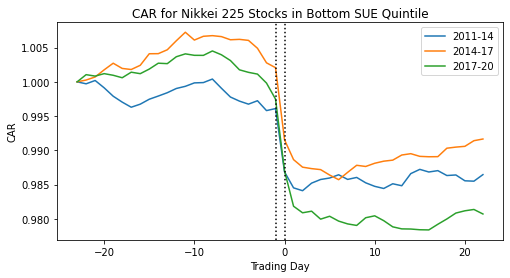

In [8]:
date0, date1 = pd.to_datetime('2005-01-01'), pd.to_datetime('2008-01-01')
date2, date3 = pd.to_datetime('2010-01-01'), pd.to_datetime('2014-01-01')
date4, date5 = pd.to_datetime('2017-01-01'), pd.to_datetime('2020-01-01')

top_quintile = nk_sue_df[nk_sue_df['sue_nm_quantiles_nk'].isin([0, 1])]
# top_quintile_period_0 = top_quintile[(top_quintile['eff_anndats'] >= date0) & (top_quintile['eff_anndats'] <= date1)]
# top_quintile_period_1 = top_quintile[(top_quintile['eff_anndats'] >= date1) & (top_quintile['eff_anndats'] <= date2)]
top_quintile_period_2 = top_quintile[(top_quintile['eff_anndats'] >= date2) & (top_quintile['eff_anndats'] <= date3)]
top_quintile_period_3 = top_quintile[(top_quintile['eff_anndats'] >= date3) & (top_quintile['eff_anndats'] <= date4)]
top_quintile_period_4 = top_quintile[(top_quintile['eff_anndats'] >= date4) & (top_quintile['eff_anndats'] <= date5)]

plt.figure(figsize=(8,4))
# plt.plot(get_plot_data(top_quintile_period_0), label='2005-08')
# plt.plot(get_plot_data(top_quintile_period_1), label='2008-11')
plt.plot(get_plot_data(top_quintile_period_2), label='2011-14')
plt.plot(get_plot_data(top_quintile_period_3), label='2014-17')
plt.plot(get_plot_data(top_quintile_period_4), label='2017-20')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei 225 Stocks in Bottom SUE Quintile')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

# plt.savefig('images/top_sue_decile_car')
plt.show()

# top_quintile.groupby(['yr'])[['sue_nm']].mean()

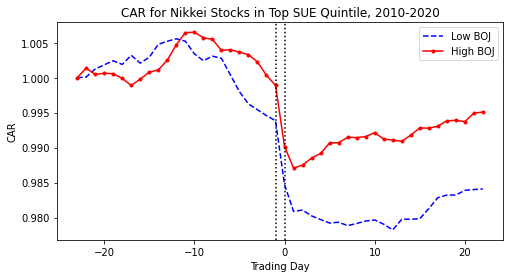

LOW: 311
HIGH: 348


In [9]:
top_quintile_sue = nk_sue_df[nk_sue_df['sue_nm_quantiles_nk'].isin([0, 1])]
date1, date2 = pd.to_datetime('2010-12-10'), pd.to_datetime('2020-01-01')
top_quintile_sue = top_quintile_sue[(top_quintile_sue['eff_anndats'] >= date1) & 
                                    (top_quintile_sue['eff_anndats'] <= date2)]

top_quintile_sue_low_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([0, 1])]
top_quintile_sue_high_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([9, 8])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(top_quintile_sue_low_boj), label='Low BOJ', color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_boj), label='High BOJ', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile, 2010-2020')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

# plt.savefig(PATH+'images/nov_1/predrift_2010_2020')
plt.show()

print('LOW:', get_num_fm_qtrs(top_quintile_sue_low_boj))
print('HIGH:', get_num_fm_qtrs(top_quintile_sue_high_boj))

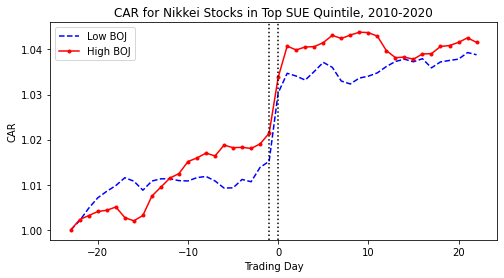

LOW: 174
HIGH: 172


In [15]:
top_quintile_sue = nk_sue_df[nk_sue_df['sue_nm_quantiles_nk'].isin([9, 8])]
date1, date2 = pd.to_datetime('2010-12-10'), pd.to_datetime('2020-01-01')
top_quintile_sue = top_quintile_sue[(top_quintile_sue['eff_anndats'] >= date1) & 
                                    (top_quintile_sue['eff_anndats'] <= date2)]

top_quintile_sue_low_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([0])]
top_quintile_sue_high_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([9])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(top_quintile_sue_low_boj), label='Low BOJ', color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_boj), label='High BOJ', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile, 2010-2020')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

# plt.savefig(PATH+'images/nov_1/predrift_2010_2020')
plt.show()
print('LOW:', get_num_fm_qtrs(top_quintile_sue_low_boj))
print('HIGH:', get_num_fm_qtrs(top_quintile_sue_high_boj))

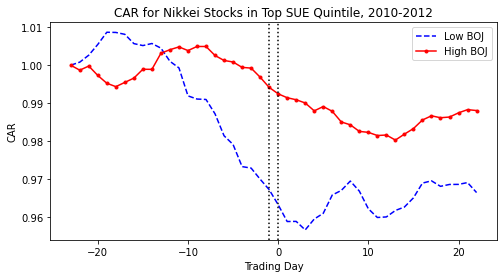

LOW: 58
HIGH: 85


In [11]:
top_quintile_sue = nk_sue_df[nk_sue_df['sue_nm_quantiles_nk'].isin([0, 1])]
date1, date2 = pd.to_datetime('2010-12-10'), pd.to_datetime('2013-01-01')
top_quintile_sue = top_quintile_sue[(top_quintile_sue['eff_anndats'] >= date1) & 
                                    (top_quintile_sue['eff_anndats'] <= date2)]

top_quintile_sue_low_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([0, 1])]
top_quintile_sue_high_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([9, 8])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(top_quintile_sue_low_boj), label='Low BOJ',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_boj), label='High BOJ', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile, 2010-2012')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

plt.savefig(PATH+'images/nov_1/predrift_2010_2012')
plt.show()

print('LOW:', get_num_fm_qtrs(top_quintile_sue_low_boj))
print('HIGH:', get_num_fm_qtrs(top_quintile_sue_high_boj))

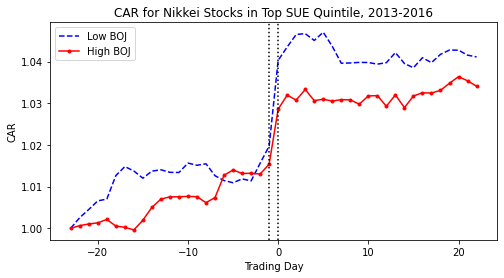

LOW: 126
HIGH: 149


In [12]:
top_quintile_sue = nk_sue_df[nk_sue_df['sue_nm_deciles'].isin([9, 8])]
date1, date2 = pd.to_datetime('2013-01-01'), pd.to_datetime('2016-12-31')
top_quintile_sue = top_quintile_sue[(top_quintile_sue['eff_anndats'] >= date1) & 
                                    (top_quintile_sue['eff_anndats'] <= date2)]

top_quintile_sue_low_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([0, 1])]
top_quintile_sue_high_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([9, 8])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(top_quintile_sue_low_boj), label='Low BOJ',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_boj), label='High BOJ', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile, 2013-2016')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

plt.savefig(PATH+'images/nov_1/predrift_2013_2016')
plt.show()

print('LOW:', get_num_fm_qtrs(top_quintile_sue_low_boj))
print('HIGH:', get_num_fm_qtrs(top_quintile_sue_high_boj))

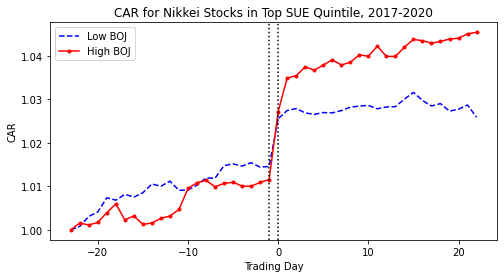

LOW: 109
HIGH: 133


In [13]:
top_quintile_sue = nk_sue_df[nk_sue_df['sue_nm_deciles'].isin([9, 8])]
date1, date2 = pd.to_datetime('2017-01-01'), pd.to_datetime('2020-01-01')
top_quintile_sue = top_quintile_sue[(top_quintile_sue['eff_anndats'] >= date1) & 
                                    (top_quintile_sue['eff_anndats'] <= date2)]

top_quintile_sue_low_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([0, 1])]
top_quintile_sue_high_boj = top_quintile_sue[top_quintile_sue['boj_share_shares_quantiles_nk'].isin([9, 8])]

plt.figure(figsize=(8,4))
plt.plot(get_plot_data(top_quintile_sue_low_boj), label='Low BOJ',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_boj), label='High BOJ', color='r', marker='.')
plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile, 2017-2020')
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()

plt.savefig(PATH+'images/nov_1/predrift_2017_2020')
plt.show()

print('LOW:', get_num_fm_qtrs(top_quintile_sue_low_boj))
print('HIGH:', get_num_fm_qtrs(top_quintile_sue_high_boj))

## Top Quintile SUEs, 2010 Prices

In [24]:
weight_df = pd.read_pickle(PATH+'checkpoint_data/index_weights.pkl')
nk_weights_2010 = weight_df[(weight_df['indexlistmnem']=='LJAPDOWA') & (weight_df['month']==11) & (weight_df['yr']==2010)]
nk_weights_2010['2010_nk_weight_decile'] = pd.qcut(nk_weights_2010['weight'], 10, labels=False)
nk_weights_2010 = nk_weights_2010[['sedol', '2010_nk_weight_decile', 'weight']]
nk_weights_2010.columns = ['sedol', '2010_nk_weight_decile', 'nk_weight']

nk_sue_df = sue_df_final[sue_df_final['nk_flag']==1]
nk_sue_df_w_2010_weights = pd.merge(nk_sue_df, 
                                    nk_weights_2010, 
                                    left_on=['SEDOL'], 
                                    right_on=['sedol'], 
                                    how='left').drop(columns='sedol')

<ipython-input-24-e6a98a4dfe2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nk_weights_2010['2010_nk_weight_decile'] = pd.qcut(nk_weights_2010['weight'], 10, labels=False)


In [25]:
# date1=pd.to_datetime('2005-01-01')
# date2=pd.to_datetime('2010-12-01')

# top_quintile_sue = nk_sue_df_w_2010_weights[(nk_sue_df_w_2010_weights['sue_nm_deciles'] == 9) & 
#                                             (nk_sue_df_w_2010_weights['eff_anndats'] >= date1) & 
#                                             (nk_sue_df_w_2010_weights['eff_anndats'] <= date2)]

# top_quintile_sue_low_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([0, 1, 2, 3, 4])]
# top_quintile_sue_high_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([9, 8, 7, 6, 5])]

# plt.figure(figsize=(8,4))

# # plt.plot(get_plot_data(top_quintile_sue), label='Nikkei Stocks Aggregate', color='g', marker='.')
# plt.plot(get_plot_data(top_quintile_sue_low_price), label='Nikkei Stocks w/ Low 2010 Price',color='b', ls='--')
# plt.plot(get_plot_data(top_quintile_sue_high_price), label='Nikkei Stocks w/ High 2010 Price', color='r', marker='.')

# plt.axvline(x=0, color='k', ls=':')
# plt.title('CAR for Nikkei Stocks in Top SUE Quintile: ' + str(date1.year) + '-' + str(date2.year))
# plt.xlabel('Trading Day')
# plt.ylabel('CAR')
# plt.legend()

# plt.savefig(PATH+'images/oct20/predrift_2')
# plt.legend()
# plt.show()

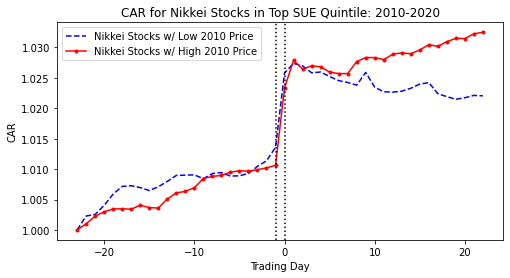

In [26]:
date1=pd.to_datetime('2010-12-10')
date2=pd.to_datetime('2020-01-01')

top_quintile_sue = nk_sue_df_w_2010_weights[(nk_sue_df_w_2010_weights['sue_nm_deciles'].isin([9, 8])) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] >= date1) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] <= date2)]

top_quintile_sue_low_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([0, 1])]
top_quintile_sue_high_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([9, 8])]

plt.figure(figsize=(8,4))

plt.plot(get_plot_data(top_quintile_sue_low_price), label='Nikkei Stocks w/ Low 2010 Price',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_price), label='Nikkei Stocks w/ High 2010 Price', color='r', marker='.')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile: ' + str(date1.year) + '-' + str(date2.year))
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()
plt.savefig(PATH+'images/nov_1/predrift_price_2010_2020')
plt.show()

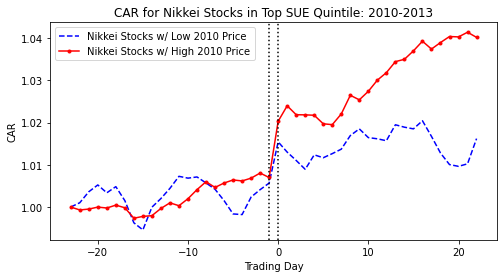

In [27]:
date1=pd.to_datetime('2010-12-10')
date2=pd.to_datetime('2013-06-01')

top_quintile_sue = nk_sue_df_w_2010_weights[(nk_sue_df_w_2010_weights['sue_nm_deciles'].isin([9, 8])) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] >= date1) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] <= date2)]

top_quintile_sue_low_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([0, 1])]
top_quintile_sue_high_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([9, 8])]

plt.figure(figsize=(8,4))

plt.plot(get_plot_data(top_quintile_sue_low_price), label='Nikkei Stocks w/ Low 2010 Price',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_price), label='Nikkei Stocks w/ High 2010 Price', color='r', marker='.')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile: ' + str(date1.year) + '-' + str(date2.year))
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()
plt.savefig(PATH+'images/nov_1/predrift_price_2010_2013')
plt.show()

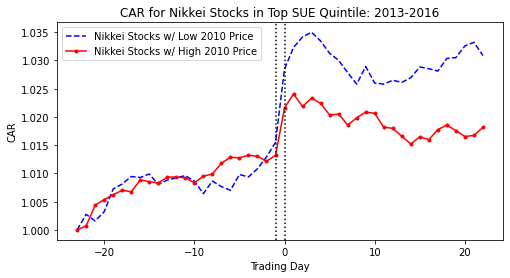

In [28]:
date1=pd.to_datetime('2013-06-10')
date2=pd.to_datetime('2016-12-31')

top_quintile_sue = nk_sue_df_w_2010_weights[(nk_sue_df_w_2010_weights['sue_nm_deciles'].isin([9, 8])) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] >= date1) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] <= date2)]

top_quintile_sue_low_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([0, 1,])]
top_quintile_sue_high_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([9, 8])]

plt.figure(figsize=(8,4))

plt.plot(get_plot_data(top_quintile_sue_low_price), label='Nikkei Stocks w/ Low 2010 Price',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_price), label='Nikkei Stocks w/ High 2010 Price', color='r', marker='.')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile: ' + str(date1.year) + '-' + str(date2.year))
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()
plt.savefig(PATH+'images/nov_1/predrift_price_2013_2016')
plt.show()

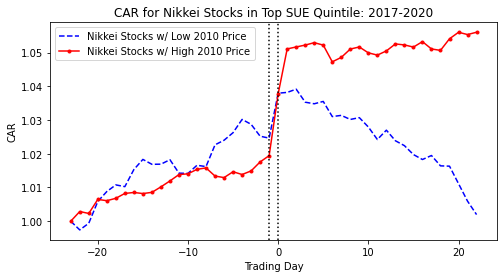

In [41]:
date1=pd.to_datetime('2017-01-01')
date2=pd.to_datetime('2020-01-01')

top_quintile_sue = nk_sue_df_w_2010_weights[(nk_sue_df_w_2010_weights['sue_nm_deciles'].isin([9])) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] >= date1) & 
                                            (nk_sue_df_w_2010_weights['eff_anndats'] <= date2)]

top_quintile_sue_low_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([0, 1])]
top_quintile_sue_high_price = top_quintile_sue[top_quintile_sue['2010_nk_weight_decile'].isin([9, 8])]

plt.figure(figsize=(8,4))

plt.plot(get_plot_data(top_quintile_sue_low_price), label='Nikkei Stocks w/ Low 2010 Price',color='b', ls='--')
plt.plot(get_plot_data(top_quintile_sue_high_price), label='Nikkei Stocks w/ High 2010 Price', color='r', marker='.')

plt.axvline(x=0, color='k', ls=':')
plt.axvline(x=-1, color='k', ls=':')

plt.title('CAR for Nikkei Stocks in Top SUE Quintile: ' + str(date1.year) + '-' + str(date2.year))
plt.xlabel('Trading Day')
plt.ylabel('CAR')
plt.legend()
plt.savefig(PATH+'images/nov_1/predrift_price_2017_2020')
plt.show()

In [93]:
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2006-01-01'), date2=pd.to_datetime('2007-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2007-01-01'), date2=pd.to_datetime('2008-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2008-01-01'), date2=pd.to_datetime('2009-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2009-01-01'), date2=pd.to_datetime('2010-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2010-01-01'), date2=pd.to_datetime('2011-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2011-01-01'), date2=pd.to_datetime('2012-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2012-01-01'), date2=pd.to_datetime('2013-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2013-01-01'), date2=pd.to_datetime('2014-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2014-01-01'), date2=pd.to_datetime('2015-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2015-01-01'), date2=pd.to_datetime('2016-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2016-01-01'), date2=pd.to_datetime('2017-01-01'))
# get_price_cond_pre_drift_graphs(date1=pd.to_datetime('2017-01-01'), date2=pd.to_datetime('2018-01-01'))